# Back testing results from models built
---

# 1. Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from keras.models import load_model

---

# 2. Choose company and timeline

In [2]:
ticker = "MSFT"
month = "1"
path = f"../TDL_Project_Data/{ticker}_year1_month{month}.csv"
stock = pd.read_csv(path, parse_dates=['time'])

In [3]:
stock.head()

,time,open,high,low,close,volume,company,price_1_min_ahead,price_2_min_ahead,price_3_min_ahead,...,EMA,MACD,MACD_Signal,change,gain,loss,avg_gain,avg_loss,rs,RSI
0,2021-04-23 15:53:00,260.93,261.11,260.890,261.0000,105102,MSFT,260.93,261.18,261.05,...,261.146603,-0.133621,-0.145338,0.0700,0.07,0.0000,0.029490,0.063490,0.464483,31.716498
1,2021-04-23 15:52:00,260.81,260.98,260.810,260.9100,82132,MSFT,261.00,260.93,261.18,...,261.124069,-0.136377,-0.143545,-0.0900,0.00,0.0900,0.028015,0.064815,0.432235,30.179035
2,2021-04-23 15:51:00,261.05,261.17,260.800,260.8000,136199,MSFT,260.91,261.00,260.93,...,261.093205,-0.145757,-0.143988,-0.1100,0.00,0.1100,0.026615,0.067075,0.396792,28.407387
3,2021-04-23 15:50:00,261.01,261.09,261.005,261.0400,50257,MSFT,260.80,260.91,261.00,...,261.088138,-0.132300,-0.141650,0.2400,0.24,0.0000,0.037284,0.063721,0.585113,36.913021
4,2021-04-23 15:49:00,261.02,261.08,260.990,260.9946,56559,MSFT,261.04,260.80,260.91,...,261.079230,-0.123870,-0.138094,-0.0454,0.00,0.0454,0.035420,0.062805,0.563965,36.059951


---

# 3. Visualize compnay's stock data

## 3.1. Sample data of Stock price, volume, Simple moving average and Bollinger bands

No handles with labels found to put in legend.


Text(0.5, 1.0, '')

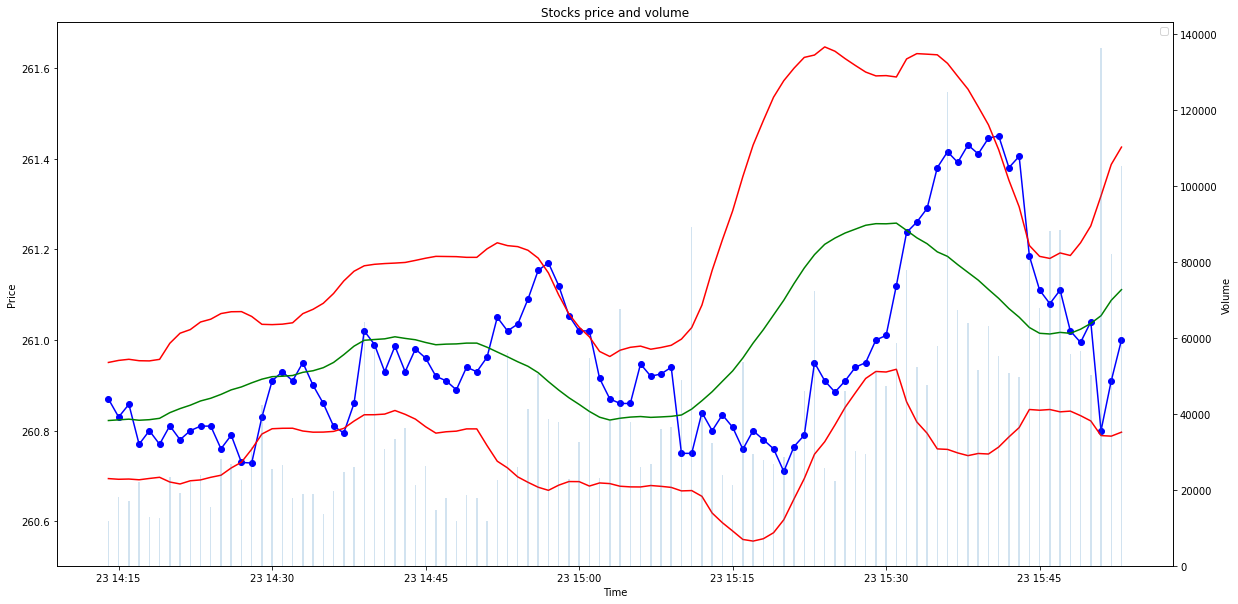

In [4]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], stock['SMA'][:100], label='Simple moving Average', color='g')

ax1.plot(stock['time'][:100], stock['up_band_2'][:100], label='', color='r')
ax1.plot(stock['time'][:100], stock['low_band_2'][:100], label='positive sentiment percentage', color='r')
    
ax2.set_xlabel("Time")
ax2.set_ylabel("Volume")
ax2.set_title(f'Stocks price and volume')
# ax1.set_ylim(0, 100)
ax2.bar(stock['time'][:100], stock['volume'][:100], width=0.0001, alpha=0.2)
ax2.grid(b=False)

ax2.legend()
plt.title("")

## 3.2. RSI, MACD and MACD Signal Indicators of the stock

Text(0.5, 1.0, 'MACD and MACD Signal')

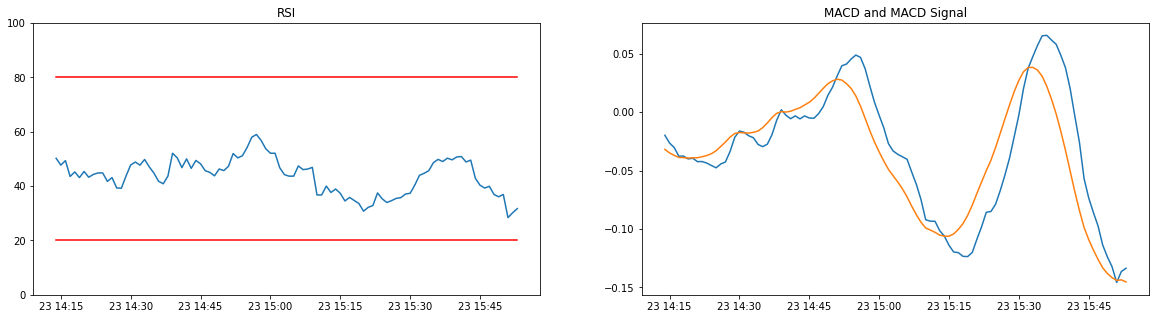

In [5]:
fig = plt.figure(figsize=(20, 5))
    
ax1 = plt.subplot2grid((1,2),(0,0))
labels = ['', '']
plt.plot(stock['time'][:100], stock['RSI'][:100])
plt.plot(stock['time'][:100], [20 for i in range(100)], color='r')
plt.plot(stock['time'][:100], [80 for i in range(100)], color='r')
plt.ylim(0, 100)
plt.title(f'RSI')
    
ax2 = plt.subplot2grid((1,2), (0, 1))
plt.plot(stock['time'][:100], stock['MACD'][:100])
plt.plot(stock['time'][:100], stock['MACD_Signal'][:100])
# plt.plot(stock['time'][:100], [20 for i in range(100)])
# plt.plot(stock['time'][:100], [80 for i in range(100)])
# plt.ylim(0, 100)
plt.title(f'MACD and MACD Signal')

---

# 4. Generate predictions on data using all models

In [6]:
models_acc = {}

## 4.1. Regression models

### 4.1.1 Regression models preprocessing

In [7]:
scaler = StandardScaler()

In [8]:
X = stock.copy()
X.drop(
    ['time', 'price_1_min_ahead', 'price_2_min_ahead', 'price_3_min_ahead', 'price_5_min_ahead', 'price_10_min_ahead', 'company', 'change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs'],
    axis='columns',
    inplace=True
)
X.head()

,open,high,low,close,volume,SMA,up_band_1,up_band_2,up_band_3,low_band_1,low_band_2,low_band_3,EMA,MACD,MACD_Signal,RSI
0,260.93,261.11,260.890,261.0000,105102,261.110990,261.268152,261.425314,261.582476,260.953828,260.796666,260.639504,261.146603,-0.133621,-0.145338,31.716498
1,260.81,260.98,260.810,260.9100,82132,261.087490,261.237277,261.387063,261.536850,260.937703,260.787917,260.638130,261.124069,-0.136377,-0.143545,30.179035
2,261.05,261.17,260.800,260.8000,136199,261.053495,261.185650,261.317806,261.449961,260.921340,260.789184,260.657029,261.093205,-0.145757,-0.143988,28.407387
3,261.01,261.09,261.005,261.0400,50257,261.036495,261.144011,261.251526,261.359042,260.928979,260.821464,260.713948,261.088138,-0.132300,-0.141650,36.913021
4,261.02,261.08,260.990,260.9946,56559,261.023725,261.119020,261.214315,261.309610,260.928430,260.833135,260.737840,261.079230,-0.123870,-0.138094,36.059951


In [9]:
X_matrix = X.values
X_matrix.shape
X_matrix = scaler.fit_transform(X_matrix)

In [10]:
print("Before reshaping: ", X_matrix.shape)
X_matrix = X_matrix.reshape(X_matrix.shape[0], X_matrix.shape[1], 1)
print("After reshaping: ", X_matrix.shape)

Before reshaping:  (8718, 16)
After reshaping:  (8718, 16, 1)


In [11]:
y = np.array(stock['price_1_min_ahead'])
print("Before reshaping: ", y.shape)
y = y.reshape(y.shape[0], 1)
print("After reshaping: ", y.shape)

Before reshaping:  (8718,)
After reshaping:  (8718, 1)


In [12]:
y = scaler.fit_transform(y)

In [13]:
def get_trades(actual_prices, target_prices):

    pred_labels = []
    for price in actual_prices - target_prices:
        # print(price)
        if price < 0:
            pred_labels.append(1)
        else:
            pred_labels.append(0)
    
    return pred_labels

### 4.1.2. LSTM Model 1

In [14]:
LSTM_model = load_model('./SavedModels/LSTM_best_model_1_59_15.h5')

In [15]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [16]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [17]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.016474082651602873
Mean Squared Error: 0.0006203655027820829
Root Mean Squared Error: 0.024907137587087017


In [18]:
LSTM_model_predictions_prices = scaler.inverse_transform(LSTM_model_predictions)
LSTM_model_predictions_prices

array([[261.05228],
       [260.88507],
       [260.92007],
       ...,
       [234.72513],
       [234.7589 ],
       [234.83775]], dtype=float32)

In [19]:
y = scaler.inverse_transform(y)
y

array([[260.93],
       [261.  ],
       [260.91],
       ...,
       [235.2 ],
       [234.66],
       [235.21]])

In [20]:
print('FOR ACTUAL PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions_prices))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions_prices))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions_prices)))

FOR ACTUAL PRICES
Mean Absolute Error: 0.16859242765002655
Mean Squared Error: 0.06497127081043043
Root Mean Squared Error: 0.2548946268763436


In [21]:
X_pred_labels = get_trades(stock['close'], LSTM_model_predictions_prices.reshape(LSTM_model_predictions_prices.shape[0]))
X_target_labels = get_trades(stock['close'], y.reshape(y.shape[0]))

In [22]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(X_pred_labels, X_target_labels))
print('PRECISION: ', metrics.precision_score(X_pred_labels, X_target_labels))
print('RECALL: ', metrics.recall_score(X_pred_labels, X_target_labels))

METRICS ON PREDICTIONS
ACCURACY:  0.6063317274604267
PRECISION:  0.6014442115071046
RECALL:  0.6000464792005578


In [23]:
models_acc['LSTM_Model_1'] = metrics.accuracy_score(X_pred_labels, X_target_labels)
print(models_acc)

{'LSTM_Model_1': 0.6063317274604267}


No handles with labels found to put in legend.


Text(0.5, 1.0, '')

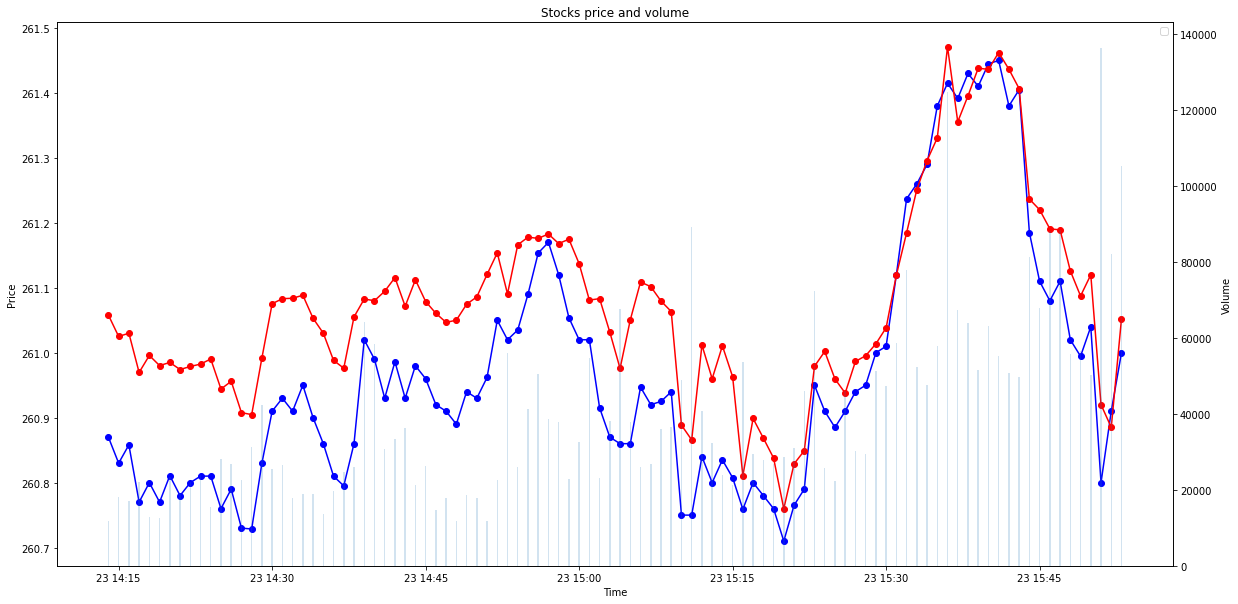

In [24]:
# Visualize predictions
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis

ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='r')

ax2.set_xlabel("Time")
ax2.set_ylabel("Volume")
ax2.set_title(f'Stocks price and volume')
# ax1.set_ylim(0, 100)
ax2.bar(stock['time'][:100], stock['volume'][:100], width=0.0001, alpha=0.2)
ax2.grid(b=False)

ax2.legend()
plt.title("")

Text(0.5, 1.0, '')

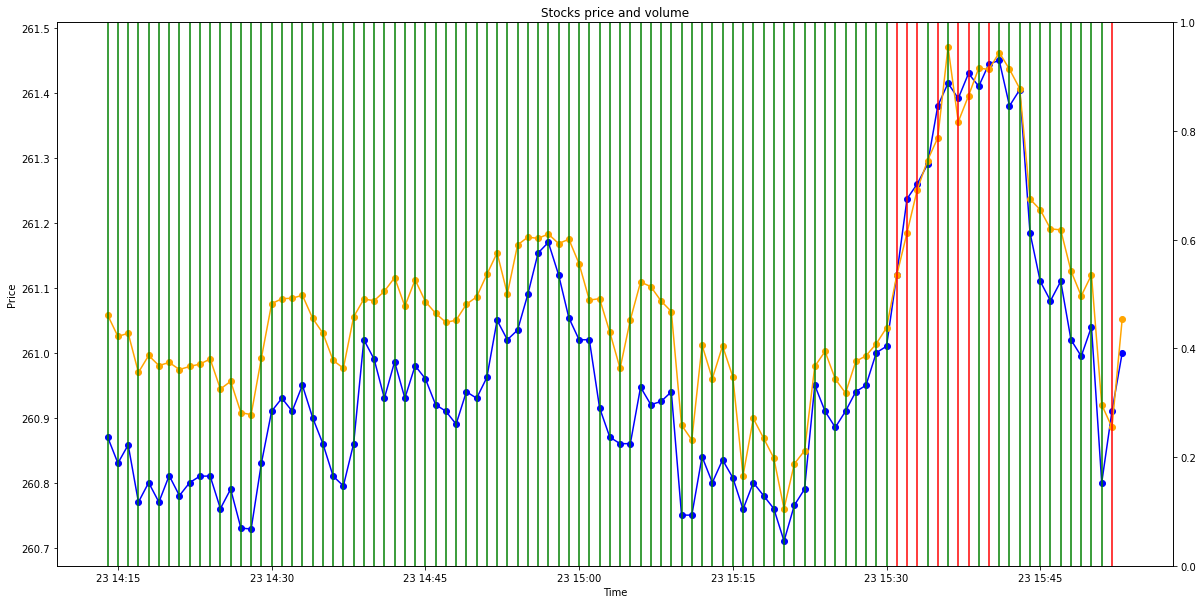

In [25]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='orange')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if X_pred_labels[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

### 4.1.3. LSTM Model 2

In [26]:
LSTM_model = load_model('./SavedModels/LSTM_best_model_2_55.h5')

In [27]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [29]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 249.7589453432326
Mean Squared Error: 62464.692366256175
Root Mean Squared Error: 249.92937475666236


In [30]:
LSTM_model_predictions_prices = scaler.inverse_transform(LSTM_model_predictions)
LSTM_model_predictions_prices

array([[261.08304],
       [261.11365],
       [261.0406 ],
       ...,
       [234.85611],
       [235.03542],
       [235.06958]], dtype=float32)

In [31]:
y = scaler.inverse_transform(y)
y

array([[2920.07918051],
       [2920.79554651],
       [2919.87450451],
       ...,
       [2656.76350732],
       [2651.23725534],
       [2656.86584532]])

In [32]:
print('FOR ACTUAL PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions_prices))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions_prices))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions_prices)))

FOR ACTUAL PRICES
Mean Absolute Error: 2555.983086833499
Mean Squared Error: 6541968.569594373
Root Mean Squared Error: 2557.7272273630692


In [33]:
X_pred_labels = get_trades(stock['close'], LSTM_model_predictions_prices.reshape(LSTM_model_predictions_prices.shape[0]))
X_target_labels = get_trades(stock['close'], y.reshape(y.shape[0]))

In [34]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(X_pred_labels, X_target_labels))
print('PRECISION: ', metrics.precision_score(X_pred_labels, X_target_labels))
print('RECALL: ', metrics.recall_score(X_pred_labels, X_target_labels))

METRICS ON PREDICTIONS
ACCURACY:  0.8347097958247305
PRECISION:  0.8347097958247305
RECALL:  1.0


In [35]:
models_acc['LSTM_Model_2'] = metrics.accuracy_score(X_pred_labels, X_target_labels)
print(models_acc)

{'LSTM_Model_1': 0.6063317274604267, 'LSTM_Model_2': 0.8347097958247305}


No handles with labels found to put in legend.


Text(0.5, 1.0, '')

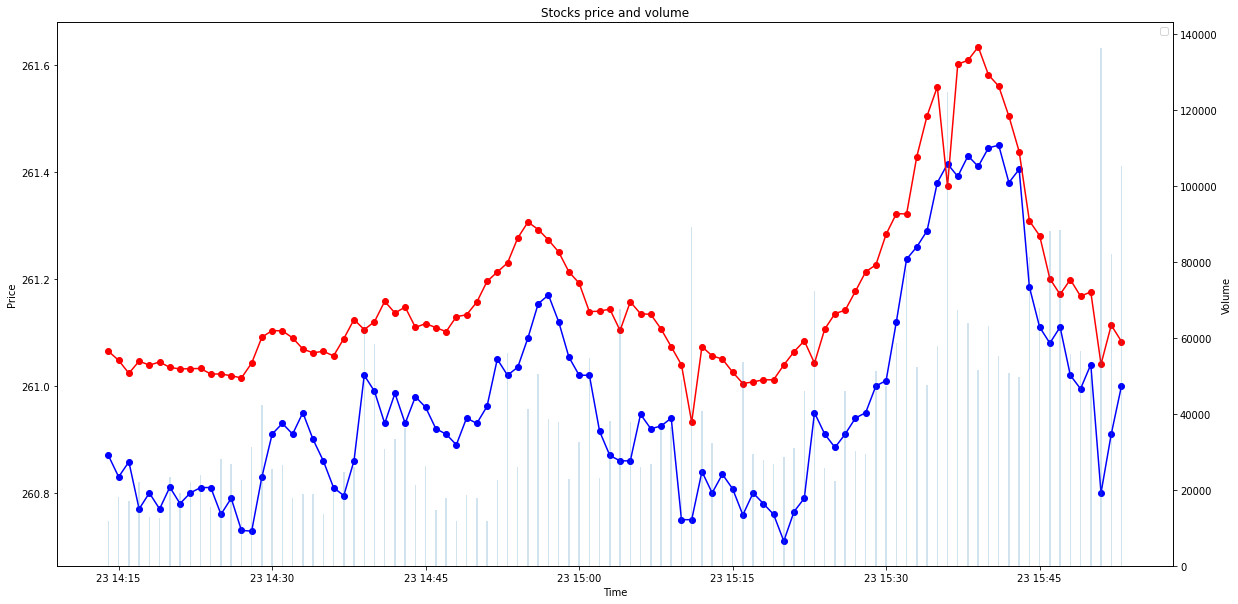

In [36]:
# Visualize predictions
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis

ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='r')

ax2.set_xlabel("Time")
ax2.set_ylabel("Volume")
ax2.set_title(f'Stocks price and volume')
# ax1.set_ylim(0, 100)
ax2.bar(stock['time'][:100], stock['volume'][:100], width=0.0001, alpha=0.2)
ax2.grid(b=False)

ax2.legend()
plt.title("")

Text(0.5, 1.0, '')

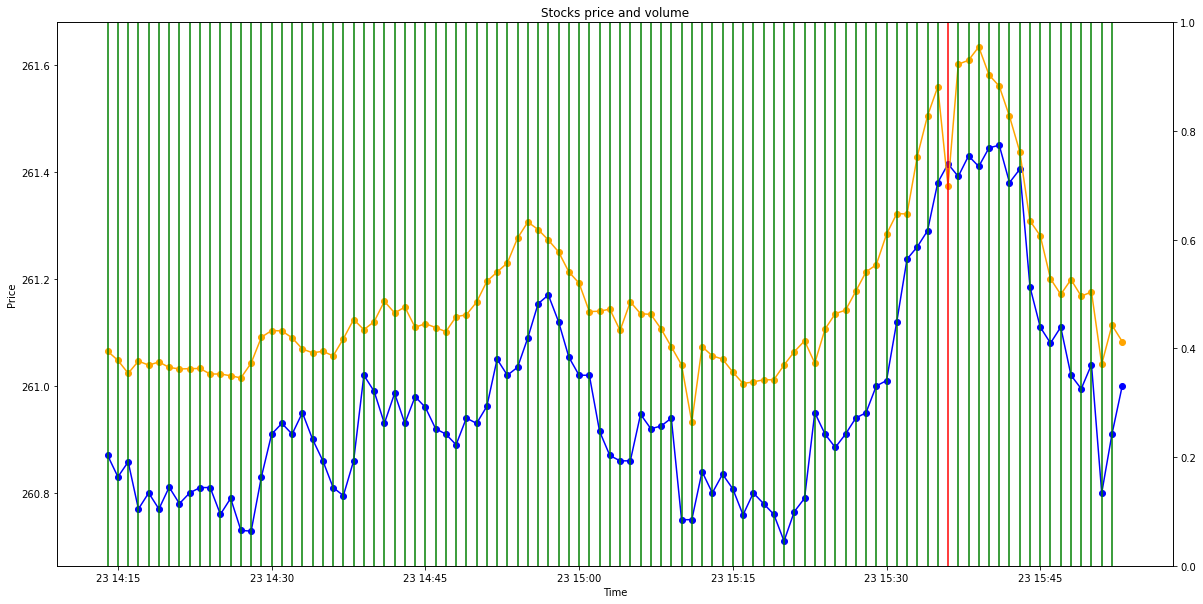

In [37]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='orange')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if X_pred_labels[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

### 4.1.4. LSTM Model 3

In [38]:
LSTM_model = load_model('./SavedModels/LSTM_best_model_3_54_9.h5')

In [39]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16, 100)           40800     
_________________________________________________________________
lstm_4 (LSTM)                (None, 16, 64)            42240     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 116,129
Trainable params: 116,129
Non-trainable params: 0
_________________________________________________________________


In [40]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [41]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 2805.909997784944
Mean Squared Error: 7883887.9097602675
Root Mean Squared Error: 2807.8261893785852


In [42]:
LSTM_model_predictions_prices = scaler.inverse_transform(LSTM_model_predictions)
LSTM_model_predictions_prices

array([[261.0966 ],
       [261.03226],
       [260.94955],
       ...,
       [234.73264],
       [234.854  ],
       [234.90019]], dtype=float32)

In [43]:
y = scaler.inverse_transform(y)
y

array([[30133.27998017],
       [30140.61112649],
       [30131.18536693],
       ...,
       [27438.56005219],
       [27382.00549482],
       [27439.60735881]])

In [44]:
print('FOR ACTUAL PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions_prices))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions_prices))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions_prices)))

FOR ACTUAL PRICES
Mean Absolute Error: 28715.121646975153
Mean Squared Error: 825684798.3109161
Root Mean Squared Error: 28734.73156845068


In [45]:
X_pred_labels = get_trades(stock['close'], LSTM_model_predictions_prices.reshape(LSTM_model_predictions_prices.shape[0]))
X_target_labels = get_trades(stock['close'], y.reshape(y.shape[0]))

In [46]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(X_pred_labels, X_target_labels))
print('PRECISION: ', metrics.precision_score(X_pred_labels, X_target_labels))
print('RECALL: ', metrics.recall_score(X_pred_labels, X_target_labels))

METRICS ON PREDICTIONS
ACCURACY:  0.5496673548979124
PRECISION:  0.5496673548979124
RECALL:  1.0


In [47]:
models_acc['LSTM_Model_3'] = metrics.accuracy_score(X_pred_labels, X_target_labels)
print(models_acc)

{'LSTM_Model_1': 0.6063317274604267, 'LSTM_Model_2': 0.8347097958247305, 'LSTM_Model_3': 0.5496673548979124}


No handles with labels found to put in legend.


Text(0.5, 1.0, '')

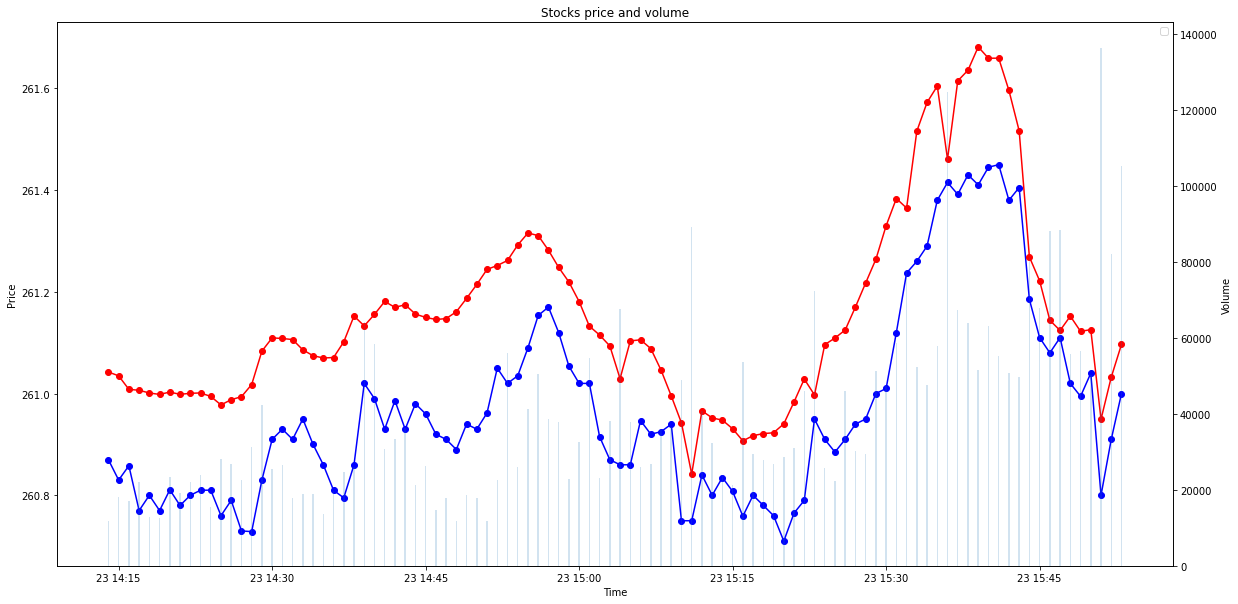

In [48]:
# Visualize predictions
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis

ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='r')

ax2.set_xlabel("Time")
ax2.set_ylabel("Volume")
ax2.set_title(f'Stocks price and volume')
# ax1.set_ylim(0, 100)
ax2.bar(stock['time'][:100], stock['volume'][:100], width=0.0001, alpha=0.2)
ax2.grid(b=False)

ax2.legend()
plt.title("")

Text(0.5, 1.0, '')

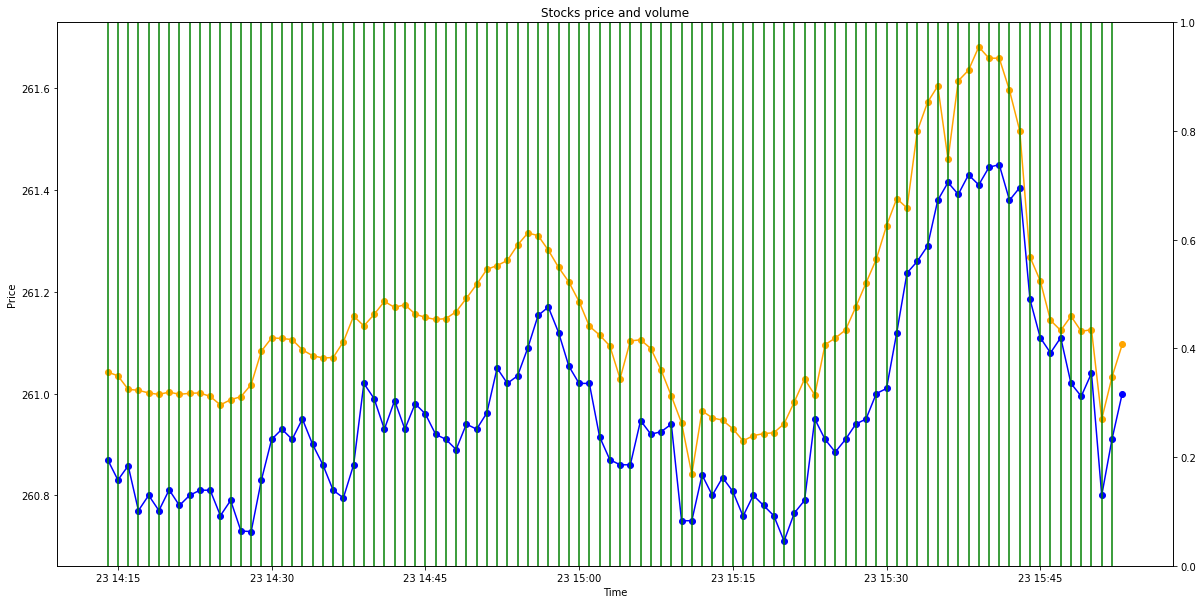

In [49]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='orange')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if X_pred_labels[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

### 4.1.5. Bidirectional LSTM Model 1

In [50]:
LSTM_model = load_model('./SavedModels/BI_LSTM_best_model_1.h5')

In [51]:
LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 16, 100)           40800     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16, 128)           84480     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 174,753
Trainable params: 174,753
Non-trainable params: 0
_________________________________________________________________


In [52]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [53]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 28964.89668748194
Mean Squared Error: 840111904.136741
Root Mean Squared Error: 28984.68395785507


In [54]:
LSTM_model_predictions_prices = scaler.inverse_transform(LSTM_model_predictions)
LSTM_model_predictions_prices

array([[260.22522],
       [260.29395],
       [260.0096 ],
       ...,
       [235.08322],
       [235.14952],
       [235.16719]], dtype=float32)

In [55]:
y = scaler.inverse_transform(y)
y

array([[308627.73346562],
       [308702.75895065],
       [308606.29761275],
       ...,
       [281050.50875167],
       [280471.74072425],
       [281061.2266781 ]])

In [56]:
print('FOR ACTUAL PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions_prices))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions_prices))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions_prices)))

FOR ACTUAL PRICES
Mean Absolute Error: 296420.9588070487
Mean Squared Error: 87985475701.7872
Root Mean Squared Error: 296623.4577739717


In [57]:
X_pred_labels = get_trades(stock['close'], LSTM_model_predictions_prices.reshape(LSTM_model_predictions_prices.shape[0]))
X_target_labels = get_trades(stock['close'], y.reshape(y.shape[0]))

In [58]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(X_pred_labels, X_target_labels))
print('PRECISION: ', metrics.precision_score(X_pred_labels, X_target_labels))
print('RECALL: ', metrics.recall_score(X_pred_labels, X_target_labels))

METRICS ON PREDICTIONS
ACCURACY:  0.2959394356503785
PRECISION:  0.2959394356503785
RECALL:  1.0


In [59]:
models_acc['Bi_LSTM_Model_1'] = metrics.accuracy_score(X_pred_labels, X_target_labels)
print(models_acc)

{'LSTM_Model_1': 0.6063317274604267, 'LSTM_Model_2': 0.8347097958247305, 'LSTM_Model_3': 0.5496673548979124, 'Bi_LSTM_Model_1': 0.2959394356503785}


No handles with labels found to put in legend.


Text(0.5, 1.0, '')

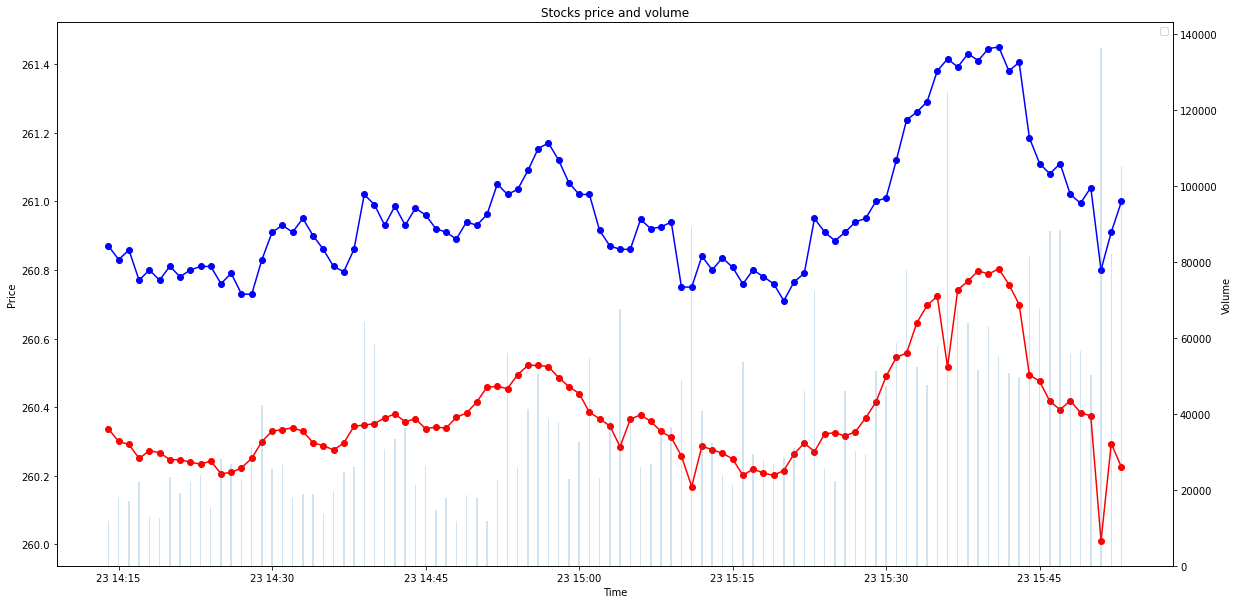

In [60]:
# Visualize predictions
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis

ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='r')

ax2.set_xlabel("Time")
ax2.set_ylabel("Volume")
ax2.set_title(f'Stocks price and volume')
# ax1.set_ylim(0, 100)
ax2.bar(stock['time'][:100], stock['volume'][:100], width=0.0001, alpha=0.2)
ax2.grid(b=False)

ax2.legend()
plt.title("")

Text(0.5, 1.0, '')

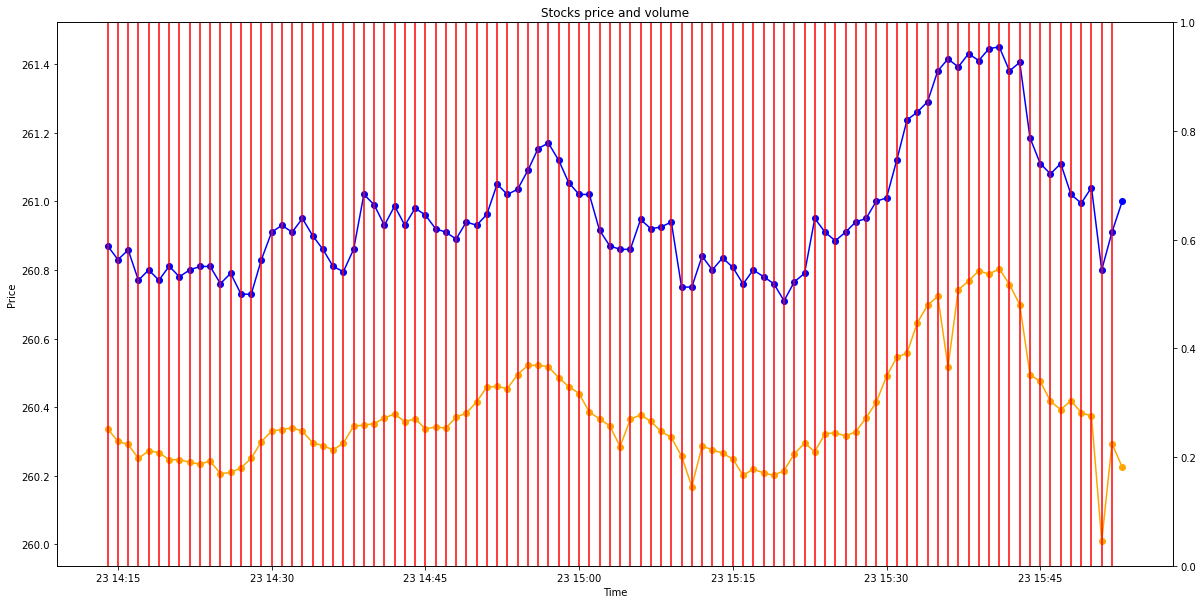

In [61]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='orange')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if X_pred_labels[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2. LSTM Classifiers

## 4.2.1 Classifiers preprocessing

In [62]:
Trades_1_min = get_trades(stock['close'], stock['price_1_min_ahead'])

In [63]:
y = np.array(Trades_1_min)
y

array([0, 1, 1, ..., 1, 0, 0])

## 4.2.2. LSTM Classifier 1

In [64]:
LSTM_model = load_model('./SavedModels/LSTM_Classifier_best_model_2_68.h5')

In [65]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [66]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [67]:
LSTM_model_predictions

array([[0.6441412 ],
       [0.66525733],
       [0.67387617],
       ...,
       [0.4802658 ],
       [0.37954053],
       [0.1700193 ]], dtype=float32)

In [68]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [69]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.4098506060474426
Mean Squared Error: 0.2026984699376845
Root Mean Squared Error: 0.45022046814609007


In [70]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [71]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.6819224592796513
PRECISION:  0.6347542511064523
RECALL:  0.693384223918575


In [72]:
models_acc['LSTM_Classifier_Model_1'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.6063317274604267, 'LSTM_Model_2': 0.8347097958247305, 'LSTM_Model_3': 0.5496673548979124, 'Bi_LSTM_Model_1': 0.2959394356503785, 'LSTM_Classifier_Model_1': 0.6819224592796513}


Text(0.5, 1.0, '')

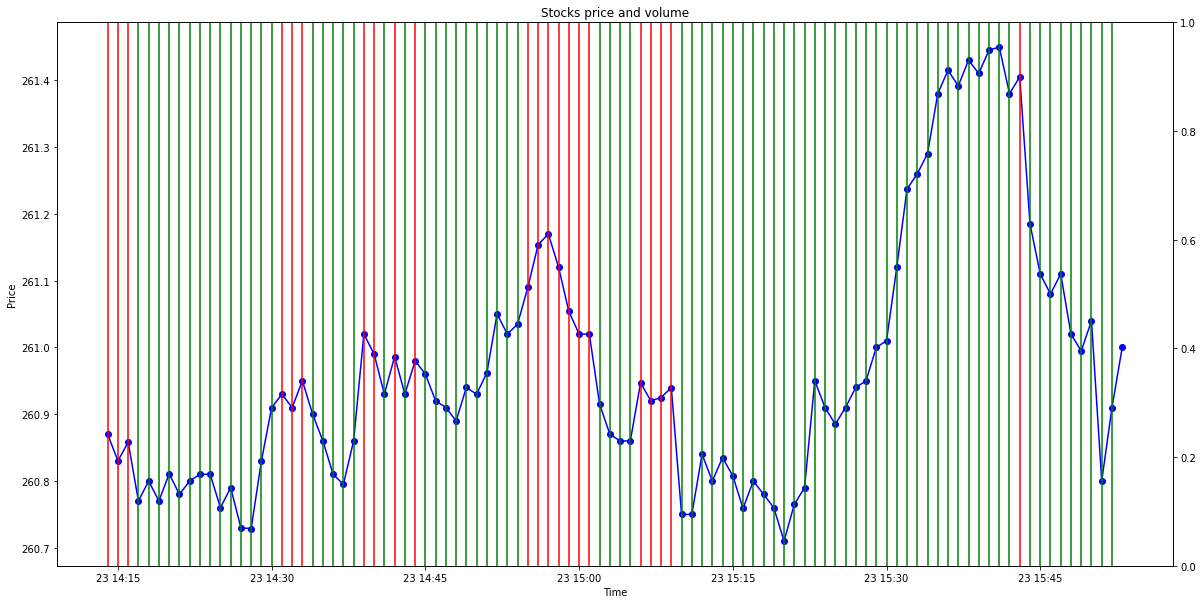

In [73]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.3. LSTM Classifier 2

In [74]:
LSTM_model = load_model('./SavedModels/LSTM_Classifier_best_model_3_69.h5')

In [75]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [76]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [77]:
LSTM_model_predictions

array([[0.7158507 ],
       [0.738831  ],
       [0.7445101 ],
       ...,
       [0.39069825],
       [0.2887873 ],
       [0.05637984]], dtype=float32)

In [78]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [79]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.4005796843475228
Mean Squared Error: 0.19813059595682952
Root Mean Squared Error: 0.44511863132970464


In [80]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [81]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.6919018123422803
PRECISION:  0.7137200093174936
RECALL:  0.6777261667772617


In [82]:
models_acc['LSTM_Classifier_Model_2'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.6063317274604267, 'LSTM_Model_2': 0.8347097958247305, 'LSTM_Model_3': 0.5496673548979124, 'Bi_LSTM_Model_1': 0.2959394356503785, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803}


Text(0.5, 1.0, '')

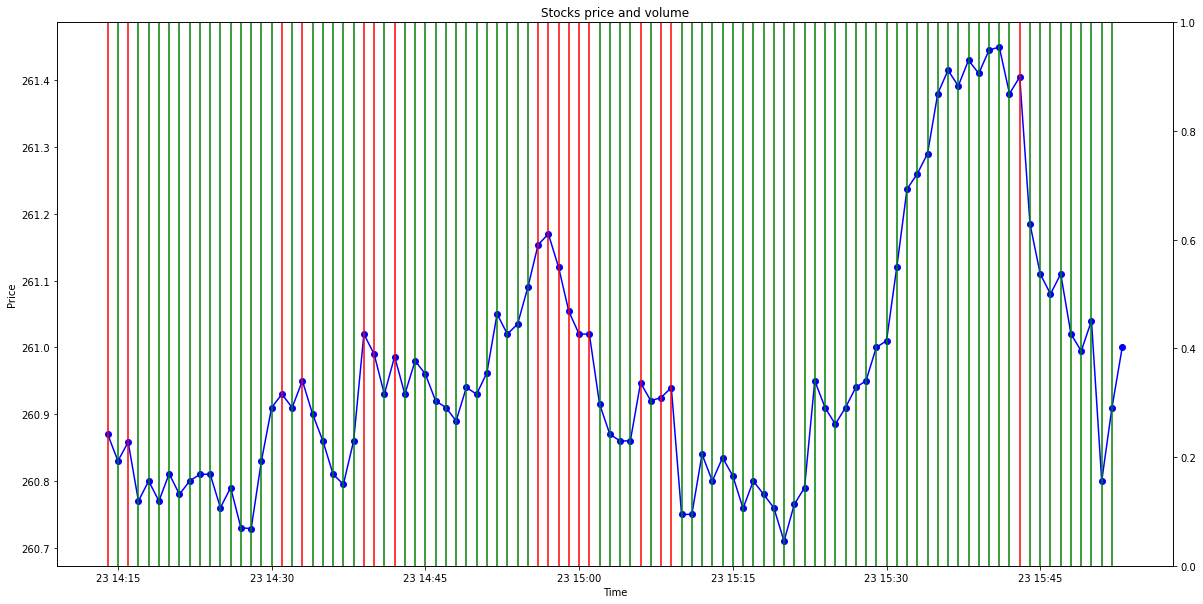

In [83]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.4. LSTM Classifier 3

In [84]:
LSTM_model = load_model('./SavedModels/LSTM_Classifier_best_model_4_69_6.h5')

In [85]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [86]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [87]:
LSTM_model_predictions

array([[0.8100692 ],
       [0.8441446 ],
       [0.8710364 ],
       ...,
       [0.39421695],
       [0.30154392],
       [0.08621246]], dtype=float32)

In [88]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [89]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.3957246532764121
Mean Squared Error: 0.19629868647117985
Root Mean Squared Error: 0.4430560759894619


In [90]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [91]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.6960311998164717
PRECISION:  0.7365478686233403
RECALL:  0.6754966887417219


In [92]:
models_acc['LSTM_Classifier_Model_3'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.6063317274604267, 'LSTM_Model_2': 0.8347097958247305, 'LSTM_Model_3': 0.5496673548979124, 'Bi_LSTM_Model_1': 0.2959394356503785, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717}


Text(0.5, 1.0, '')

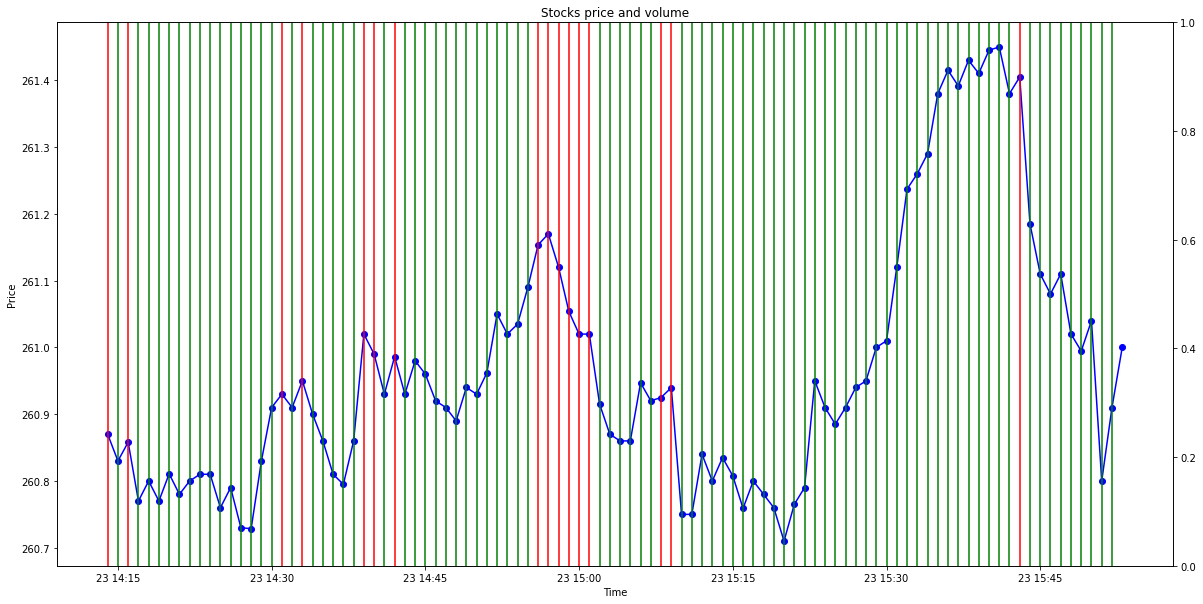

In [93]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.5. Bidirectional LSTM Classifier 1

In [94]:
LSTM_model = load_model('./SavedModels/BI_LSTM_best_model_1.h5')

In [95]:
LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 16, 100)           40800     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16, 128)           84480     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 174,753
Trainable params: 174,753
Non-trainable params: 0
_________________________________________________________________


In [96]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [97]:
LSTM_model_predictions

array([[ 1.0212704],
       [ 1.0279839],
       [ 1.000201 ],
       ...,
       [-1.4354919],
       [-1.4290127],
       [-1.4272866]], dtype=float32)

In [98]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [99]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.9278137312211091
Mean Squared Error: 1.4386761651316786
Root Mean Squared Error: 1.1994482753048081


In [100]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [101]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.503785271851342
PRECISION:  0.469601677148847
RECALL:  0.4959409594095941


In [102]:
models_acc['BI_LSTM_Classifier_Model_1'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.6063317274604267, 'LSTM_Model_2': 0.8347097958247305, 'LSTM_Model_3': 0.5496673548979124, 'Bi_LSTM_Model_1': 0.2959394356503785, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717, 'BI_LSTM_Classifier_Model_1': 0.503785271851342}


Text(0.5, 1.0, '')

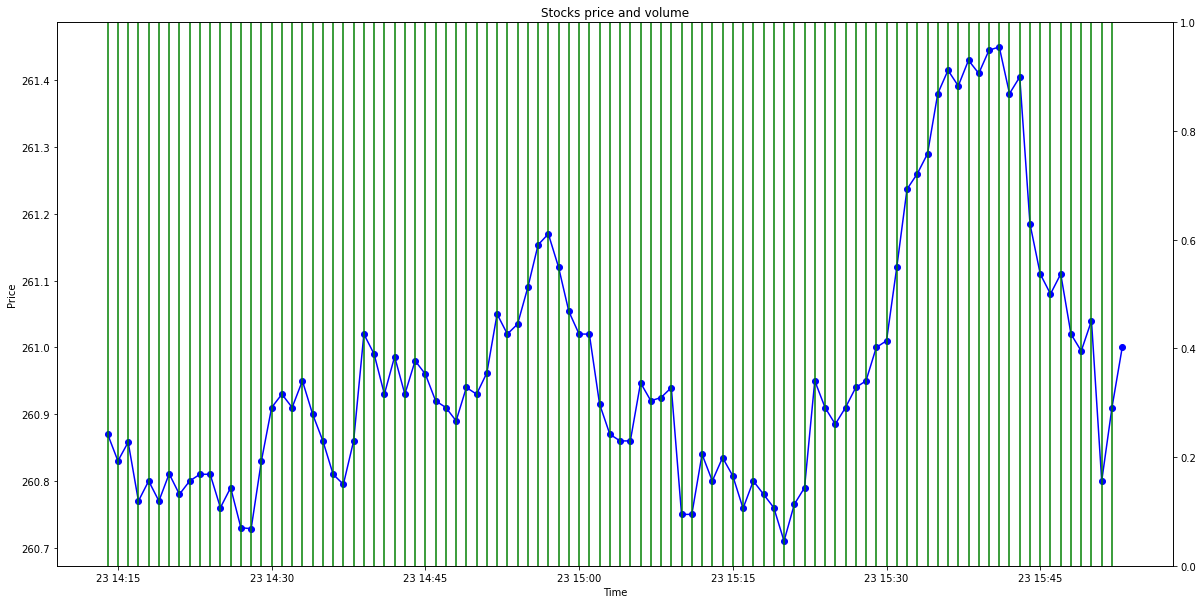

In [103]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.6. Bidirectional LSTM Classifier 2

In [104]:
LSTM_model = load_model('./SavedModels/BI_LSTM_Classifier_best_model_1_68_5.h5')

In [105]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 50)            10400     
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 50,901
Trainable params: 50,901
Non-trainable params: 0
_________________________________________________________________


In [106]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [107]:
LSTM_model_predictions

array([[0.73926806],
       [0.7750881 ],
       [0.780411  ],
       ...,
       [0.32331827],
       [0.24972355],
       [0.01997176]], dtype=float32)

In [108]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [109]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.40180965227889587
Mean Squared Error: 0.20344356664393365
Root Mean Squared Error: 0.4510471889325258


In [110]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [111]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.6853636155081441
PRECISION:  0.5844397856976473
RECALL:  0.7234717416378316


In [112]:
models_acc['BI_LSTM_Classifier_Model_2'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.6063317274604267, 'LSTM_Model_2': 0.8347097958247305, 'LSTM_Model_3': 0.5496673548979124, 'Bi_LSTM_Model_1': 0.2959394356503785, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717, 'BI_LSTM_Classifier_Model_1': 0.503785271851342, 'BI_LSTM_Classifier_Model_2': 0.6853636155081441}


Text(0.5, 1.0, '')

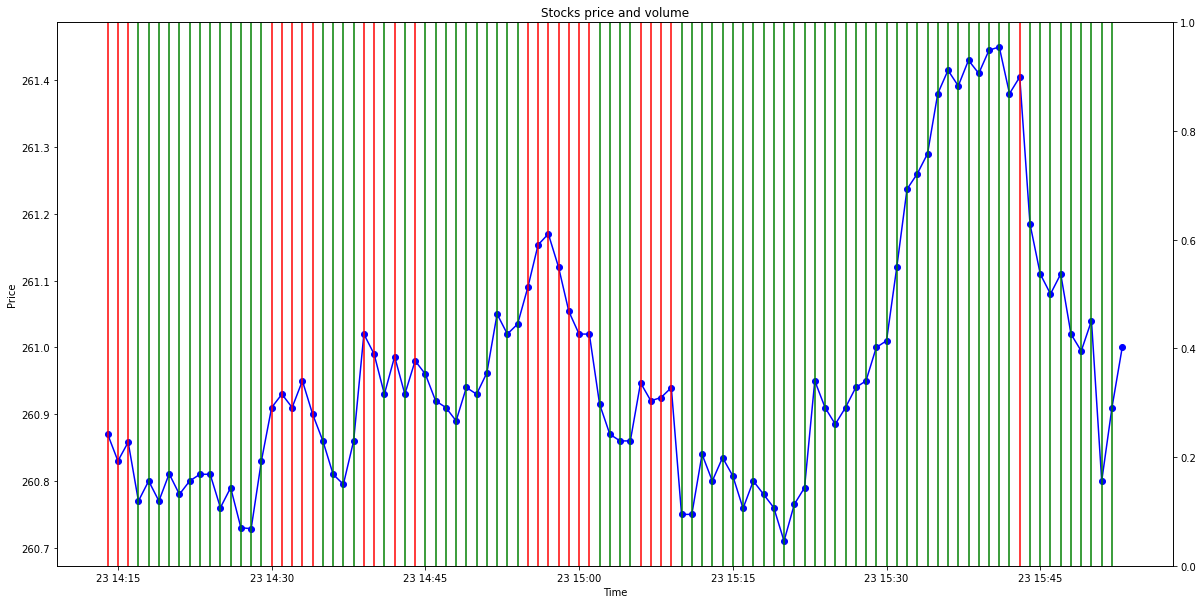

In [113]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.7. Bidirectional LSTM Classifier 3

In [114]:
LSTM_model = load_model('./SavedModels/BI_LSTM_Classifier_best_model_1_70.h5')

In [115]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 50)            10400     
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 50,901
Trainable params: 50,901
Non-trainable params: 0
_________________________________________________________________


In [116]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [117]:
LSTM_model_predictions

array([[0.7911258 ],
       [0.8064668 ],
       [0.81937563],
       ...,
       [0.43235356],
       [0.38728493],
       [0.18053202]], dtype=float32)

In [118]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [119]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.39141448209266044
Mean Squared Error: 0.1956653924484029
Root Mean Squared Error: 0.44234081029043987


In [120]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [121]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.6992429456297315
PRECISION:  0.7211740041928721
RECALL:  0.6848042468480424


In [122]:
models_acc['BI_LSTM_Classifier_Model_3'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.6063317274604267, 'LSTM_Model_2': 0.8347097958247305, 'LSTM_Model_3': 0.5496673548979124, 'Bi_LSTM_Model_1': 0.2959394356503785, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717, 'BI_LSTM_Classifier_Model_1': 0.503785271851342, 'BI_LSTM_Classifier_Model_2': 0.6853636155081441, 'BI_LSTM_Classifier_Model_3': 0.6992429456297315}


Text(0.5, 1.0, '')

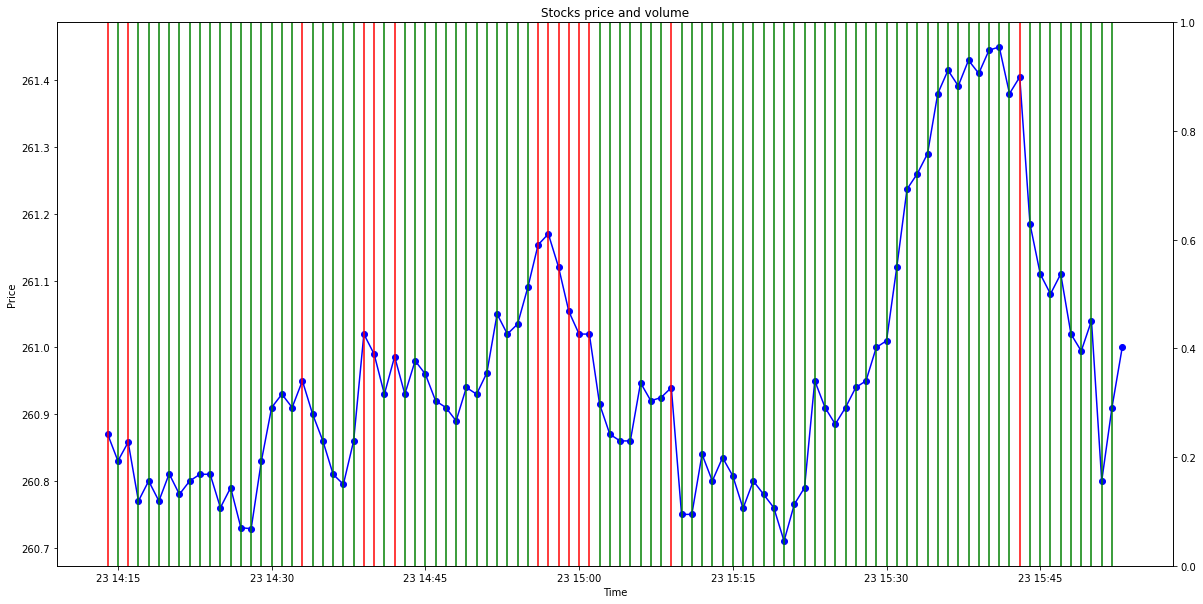

In [123]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.8. Bidirectional LSTM Classifier 4

In [124]:
LSTM_model = load_model('./SavedModels/BI_LSTM_Classifier_best_model_2_68_66.h5')

In [125]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16, 50)            10400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 100)           40400     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 111,301
Trainable params: 111,301
Non-trainable params: 0
_________________________________________________________________


In [126]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [127]:
LSTM_model_predictions

array([[0.6689186 ],
       [0.6806824 ],
       [0.7227185 ],
       ...,
       [0.44132593],
       [0.34601337],
       [0.18716696]], dtype=float32)

In [128]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [129]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.40760703325907444
Mean Squared Error: 0.2005258380415342
Root Mean Squared Error: 0.4478011143817467


In [130]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [131]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.6866253727919247
PRECISION:  0.5981830887491265
RECALL:  0.7183216783216784


In [132]:
models_acc['BI_LSTM_Classifier_Model_4'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.6063317274604267, 'LSTM_Model_2': 0.8347097958247305, 'LSTM_Model_3': 0.5496673548979124, 'Bi_LSTM_Model_1': 0.2959394356503785, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717, 'BI_LSTM_Classifier_Model_1': 0.503785271851342, 'BI_LSTM_Classifier_Model_2': 0.6853636155081441, 'BI_LSTM_Classifier_Model_3': 0.6992429456297315, 'BI_LSTM_Classifier_Model_4': 0.6866253727919247}


Text(0.5, 1.0, '')

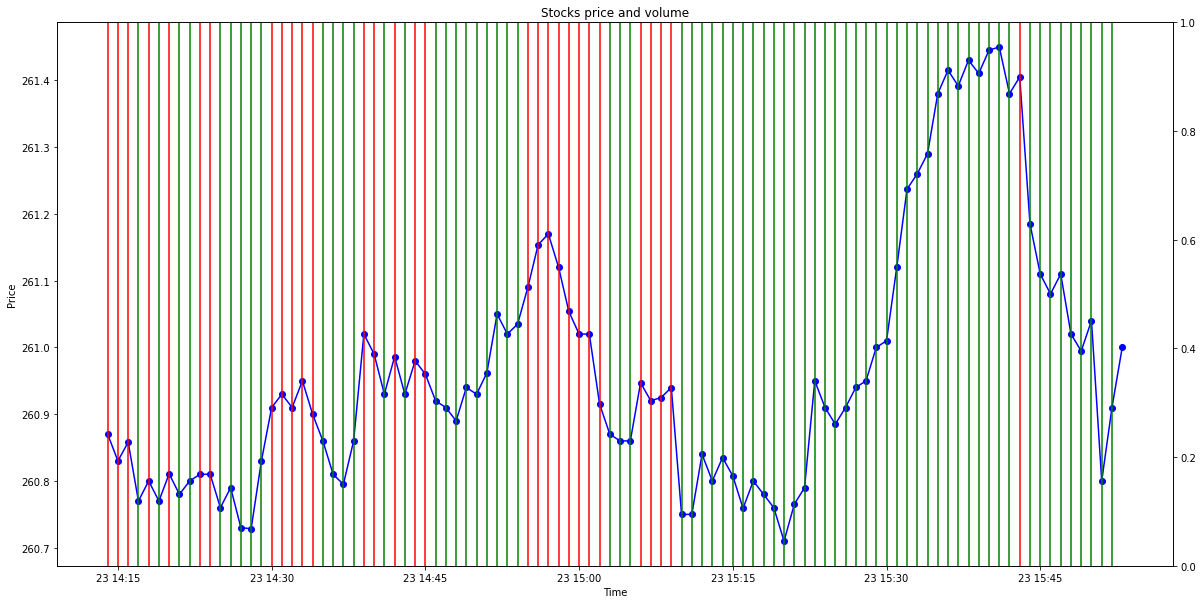

In [133]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.9. Bidirectional LSTM Classifier 5

In [134]:
LSTM_model = load_model('./SavedModels/BI_LSTM_Classifier_best_model_3_69_4.h5')

In [135]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16, 50)            10400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 100)           40400     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 111,301
Trainable params: 111,301
Non-trainable params: 0
_________________________________________________________________


In [136]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [137]:
LSTM_model_predictions

array([[0.7946126 ],
       [0.82120174],
       [0.8297181 ],
       ...,
       [0.40914786],
       [0.29947537],
       [0.14271198]], dtype=float32)

In [138]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [139]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.3856428192005871
Mean Squared Error: 0.1951733596129716
Root Mean Squared Error: 0.44178429081733045


In [140]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [141]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.694769442532691
PRECISION:  0.6738877242021896
RECALL:  0.696437168993741


In [142]:
models_acc['BI_LSTM_Classifier_Model_5'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.6063317274604267, 'LSTM_Model_2': 0.8347097958247305, 'LSTM_Model_3': 0.5496673548979124, 'Bi_LSTM_Model_1': 0.2959394356503785, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717, 'BI_LSTM_Classifier_Model_1': 0.503785271851342, 'BI_LSTM_Classifier_Model_2': 0.6853636155081441, 'BI_LSTM_Classifier_Model_3': 0.6992429456297315, 'BI_LSTM_Classifier_Model_4': 0.6866253727919247, 'BI_LSTM_Classifier_Model_5': 0.694769442532691}


Text(0.5, 1.0, '')

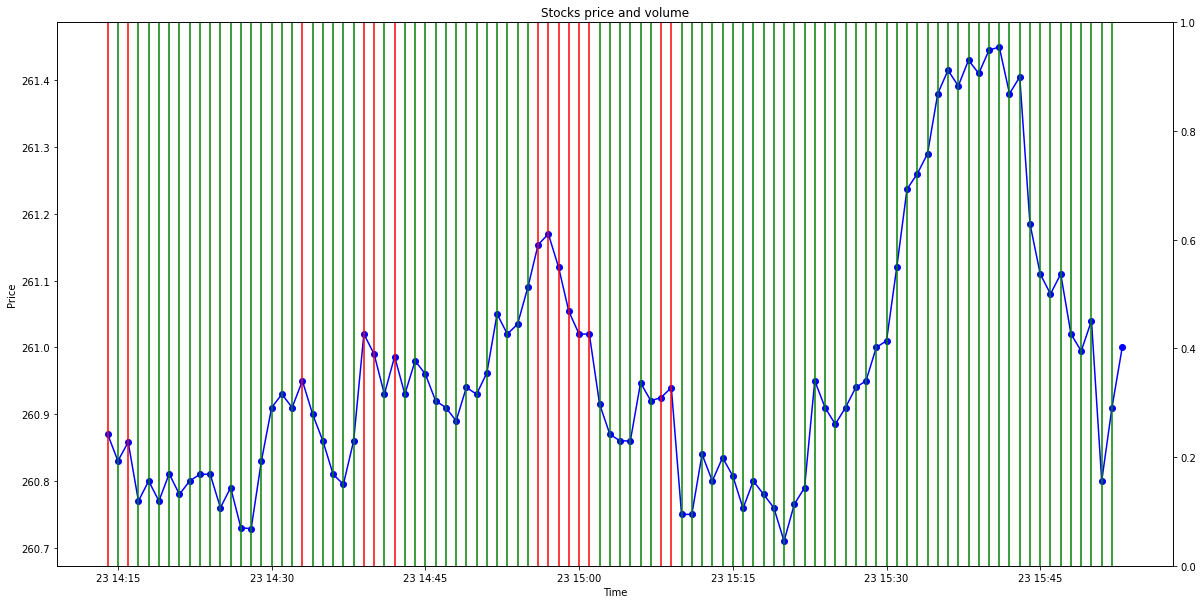

In [143]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.10. Bidirectional LSTM Classifier 6

In [144]:
LSTM_model = load_model('./SavedModels/BI_LSTM_Classifier_best_model_3_70_6.h5')

In [145]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16, 50)            10400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 100)           40400     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 111,301
Trainable params: 111,301
Non-trainable params: 0
_________________________________________________________________


In [146]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [147]:
LSTM_model_predictions

array([[0.6549171 ],
       [0.70140064],
       [0.6691027 ],
       ...,
       [0.2902843 ],
       [0.22368859],
       [0.03153571]], dtype=float32)

In [148]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [149]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.3807348651069243
Mean Squared Error: 0.19249579255303814
Root Mean Squared Error: 0.43874342451259385


In [150]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [151]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.7061252580867171
PRECISION:  0.6165851385977172
RECALL:  0.7429132753297782


In [152]:
models_acc['BI_LSTM_Classifier_Model_6'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.6063317274604267, 'LSTM_Model_2': 0.8347097958247305, 'LSTM_Model_3': 0.5496673548979124, 'Bi_LSTM_Model_1': 0.2959394356503785, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717, 'BI_LSTM_Classifier_Model_1': 0.503785271851342, 'BI_LSTM_Classifier_Model_2': 0.6853636155081441, 'BI_LSTM_Classifier_Model_3': 0.6992429456297315, 'BI_LSTM_Classifier_Model_4': 0.6866253727919247, 'BI_LSTM_Classifier_Model_5': 0.694769442532691, 'BI_LSTM_Classifier_Model_6': 0.7061252580867171}


Text(0.5, 1.0, '')

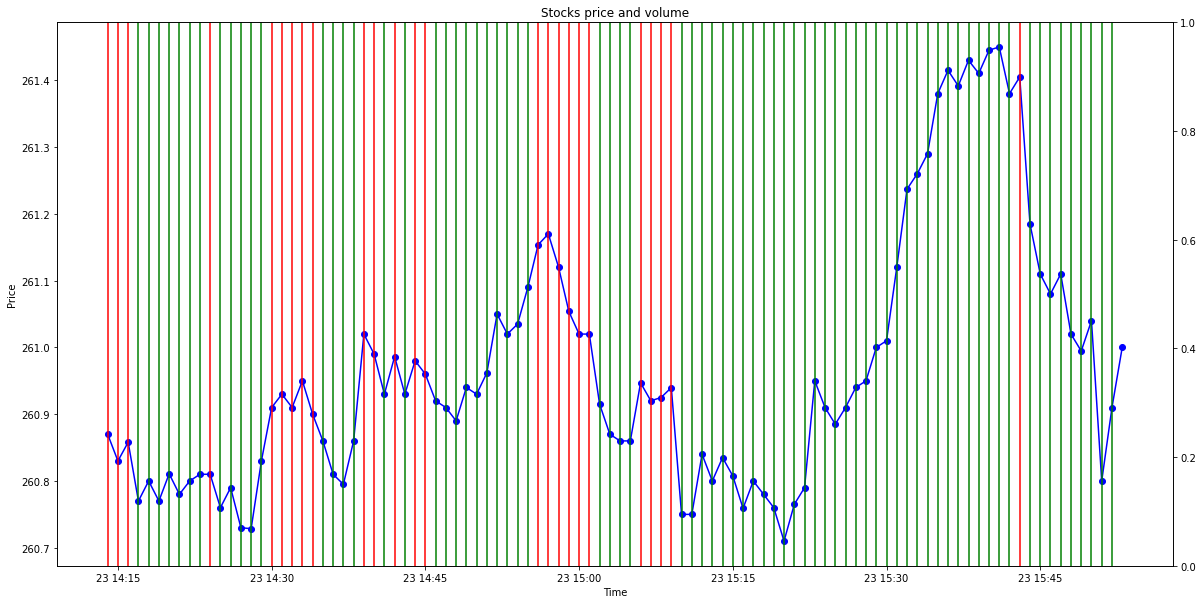

In [153]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

---

# 5. Find best model after backtest

## 5.1. Find model with highest accuracy

In [154]:
highest_acc = 0
highest_acc_model = ''
for model in models_acc:
    acc = models_acc[model]
    if acc > highest_acc:
        highest_acc = acc
        highest_acc_model = model
#     print(model, acc)
print(highest_acc_model, highest_acc)

LSTM_Model_2 0.8347097958247305


## 5.2. Predicted returns with best model

In [155]:
return_prct = (highest_acc * 100 * 1.5) - 100
print(f'Returns with model {highest_acc_model} = {return_prct} %')

Returns with model LSTM_Model_2 = 25.20646937370958 %


---